# Pipeline for High-z Radio Galaxies 04: Redshift prediction on radio AGN

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
from pycaret import regression as pyr
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

Methods to create values of metrics by redshift ranges

In [4]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

Method to plot metrics

In [5]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title, fontsize=14)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

***

## Reading data

In [6]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [7]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS',\
                     'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                      'num_imputed', 'radio_detect', 'TGSS_detect',\
                      'VLASS_detect', 'LoLSS_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [8]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [9]:
full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'LOFAR_detect'].astype(int)

In [10]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [11]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections (in LOFAR).')

In this dataset, with 6,729,647 elements,
28,251 of them are marked as AGN, 55,158 have been indentified as galaxies, and 339,407 are identified as radio detections (in LOFAR).


In [12]:
target_feat = 'Z'

---

Combine redshift values (AGN + galaxies).

In [13]:
idx_non_Z                = full_catalog_df.loc[:, target_feat].where(full_catalog_df.loc[:, target_feat] > 0).isna()
full_catalog_df.loc[idx_non_Z, target_feat] = full_catalog_df.loc[:, target_feat].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Possible correlations

In [14]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'spCl', 'band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [15]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'LOFAR_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
print('Shape of used data in HETDEX')
print('-' * 65)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 65)
print()

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (83409, 88)
Data for Modeling (Train, Test, and Calibration): (66727, 88)
Training data:                                    (53381, 88)
Testing data:                                     (6673, 88)
Calibration data:                                 (6673, 88)
Validation data:                                  (16682, 88)
-----------------------------------------------------------------



In [16]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'LOFAR_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'LOFAR_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'LOFAR_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'LOFAR_detect'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'is_AGN'] == 1) & (calibration_df.loc[:, 'LOFAR_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'LOFAR_detect'] == 1)]

In [17]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed LOFAR radio detection.')

In this dataset (HETDEX), with 8,339 elements,
8,339 of them are marked as AGN, and, from them, 8,339 have confirmed LOFAR radio detection.


Remove intermediate targets

In [18]:
cols_discard_class = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'LOFAR_detect', 'zsp']
full_catalog_df    = full_catalog_df.drop(columns=cols_discard_class)
train_test_df      = train_test_df.drop(columns=cols_discard_class)
train_df           = train_df.drop(columns=cols_discard_class)
test_df            = test_df.drop(columns=cols_discard_class)
calibration_df     = calibration_df.drop(columns=cols_discard_class)
validation_df      = validation_df.drop(columns=cols_discard_class)

---

In [19]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (8339, 80)
Data for Modeling (Train and Test): (6721, 80)
Training data:                      (5410, 80)
Testing data:                       (644, 80)
Calibration data:                   (667, 80)
Validation data:                    (1618, 80)
--------------------------------------------------


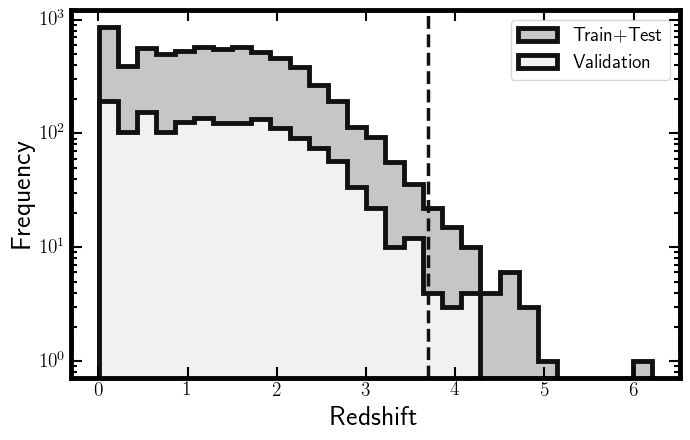

In [20]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=3.7, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [21]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [22]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [23]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [24]:
rsd_vals

z_y         313.644380
i_z         252.823351
K_W3        210.523165
i_y         167.719960
r_i         139.338013
W1_W2       134.562521
g_r         118.035755
r_z         112.817528
r_y         108.915235
g_i          98.423652
g_z          89.205338
g_y          88.435511
H_W3         70.028124
Z            66.545440
y_W1         64.706762
z_W1         58.133680
J_W3         56.546465
y_W2         55.081090
i_W1         54.645377
r_W1         54.055596
g_W1         54.041587
y_J          52.348033
z_W2         48.716860
z_J          47.743105
y_H          47.061147
i_J          45.870113
i_W2         45.532236
r_W2         43.668190
z_H          43.214128
g_W2         43.119855
r_J          43.094431
i_H          41.827059
g_J          40.680685
W1_W3        40.676479
W2_W3        40.453120
y_K          40.408440
r_H          39.702558
g_H          37.972961
z_K          37.560392
i_K          36.650700
H_K          35.345393
r_K          34.858904
J_H          33.988335
g_K        

In [25]:
correlation = norm_train_test_df.corr()

In [26]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [27]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [28]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [29]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [30]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'J_W1',
 'z_H',
 'J_W2',
 'J_W3',
 'Jmag',
 'J_W4',
 'g_K',
 'y_K',
 'r_K',
 'i_K',
 'H_W1',
 'z_K',
 'H_W2',
 'Kmag',
 'rmag',
 'zmag',
 'W2mproPM',
 'K_W1',
 'r_W4',
 'i_W4',
 'W2_W4',
 'H_W3',
 'W1mproPM',
 'r_J',
 'gmag',
 'i_J',
 'ymag',
 'g_W2',
 'r_W3',
 'J_K',
 'z_W4',
 'g_W4',
 'i_W3',
 'W1_W4',
 'y_W4',
 'z_J',
 'r_W1',
 'H_W4',
 'W2_W3',
 'r_W2',
 'z_W3',
 'i_W2',
 'i_W1',
 'y_W2',
 'Hmag',
 'z_W2',
 'W3mag',
 'g_z',
 'g_W3',
 'g_y',
 'imag',
 'g_i',
 'z_W1',
 'y_W3',
 'r_y',
 'K_W2',
 'W3_W4']

In [31]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [32]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [33]:
corr_discard = norm_train_test_discard.corr()

In [34]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
y_J       g_J         0.747370
          band_num    0.721552
W4mag     K_W3        0.702433
z_y       i_y         0.686898
K_W4      K_W3        0.683844
y_W1      g_W1        0.654304
W1_W3     Z           0.653233
band_num  H_K         0.636799
r_i       r_z         0.634480
g_r       g_W1        0.624642
r_z       i_z         0.623443
W1_W3     y_J         0.618267
band_num  W1_W3       0.598480
g_J       g_W1        0.584565
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

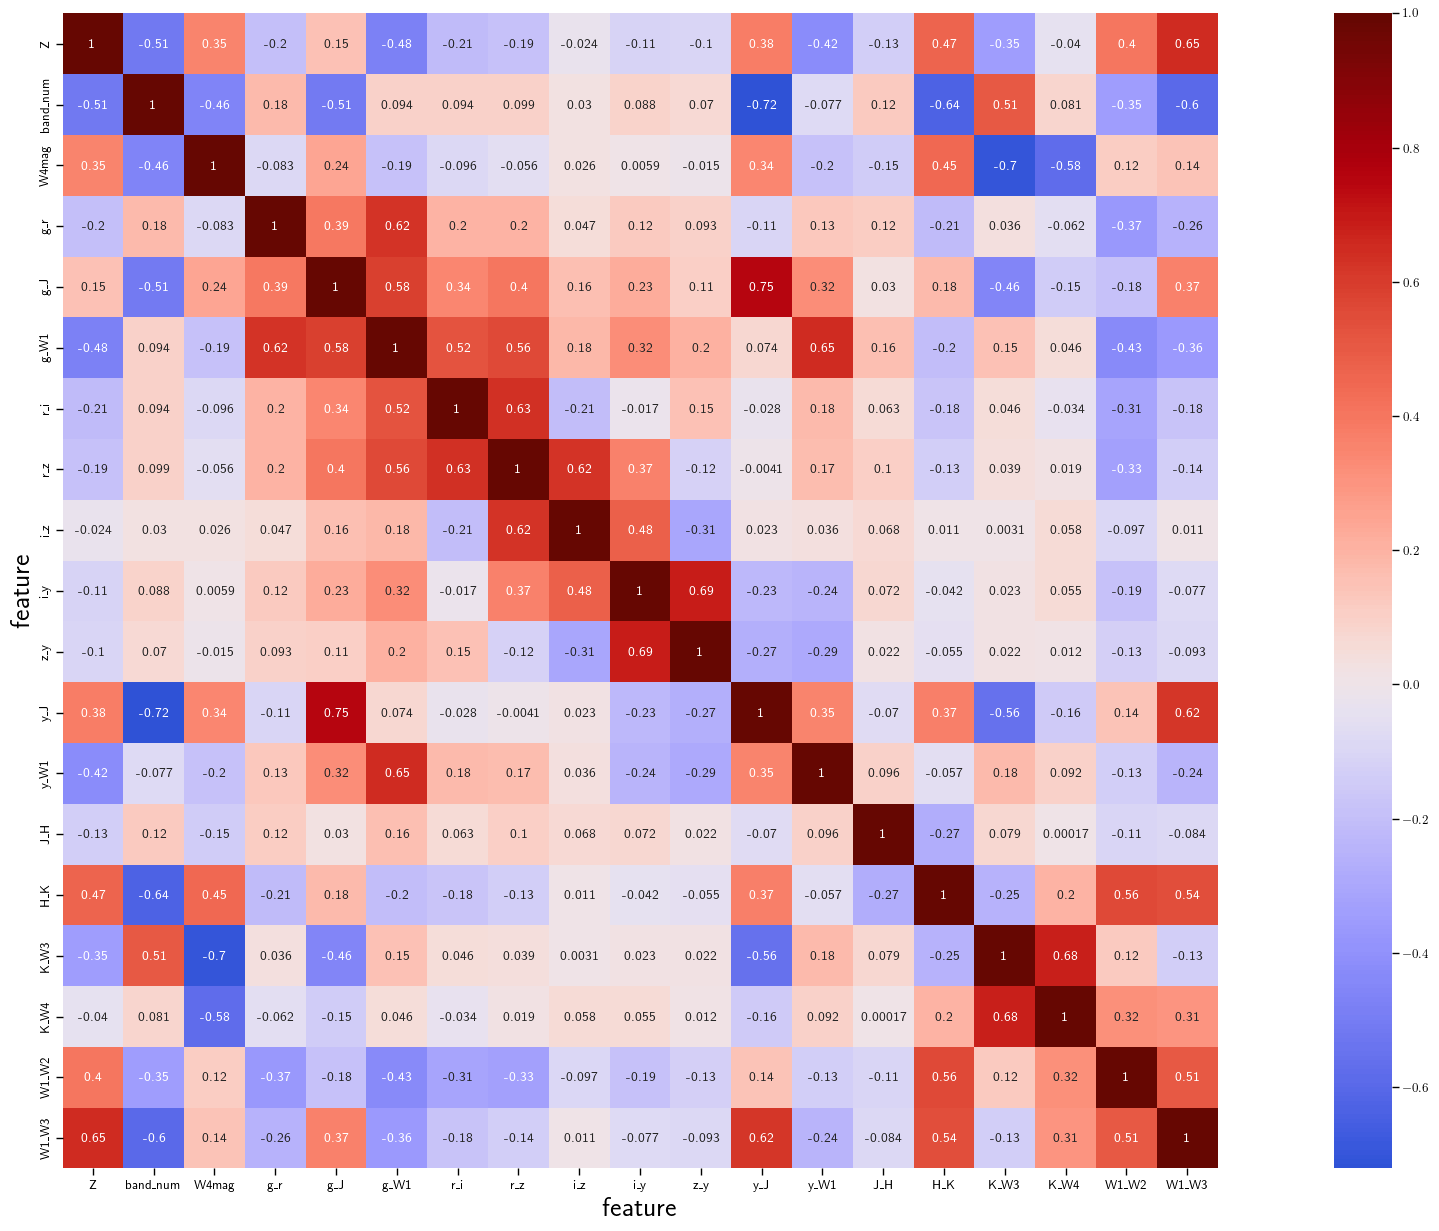

In [35]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [36]:
# norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [37]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [38]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
H_K       H_K         1.000000
Z         H_K         0.456873
J_H       band_num    0.450902
band_num  y_J         0.447762
H_K       band_num    0.440766
K_W4      W4mag       0.409423
J_H       H_K         0.346441
K_W4      K_W3        0.336074
W4mag     K_W3        0.291466
y_J       band_num    0.255204
K_W3      K_W4        0.241998
band_num  H_K         0.233539
K_W4      band_num    0.230837
K_W3      W4mag       0.217386
          y_J         0.212547
y_J       g_J         0.202707
band_num  Z           0.192695
          W1_W3       0.190467
          g_J         0.186588
W4mag     band_num    0.179254
dtype: float64

In [39]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [40]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [41]:
list_drop_pps = []

In [42]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [43]:
list_drop_pps

[]

In [44]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [45]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [46]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.192695,regression,True,mean absolute error,0.116114,0.093739,DecisionTreeRegressor()
1,H_K,Z,0.173965,regression,True,mean absolute error,0.116114,0.095914,DecisionTreeRegressor()
2,W1_W3,Z,0.172762,regression,True,mean absolute error,0.116114,0.096054,DecisionTreeRegressor()
3,J_H,Z,0.168055,regression,True,mean absolute error,0.116114,0.096600,DecisionTreeRegressor()
4,K_W4,Z,0.153888,regression,True,mean absolute error,0.116114,0.098245,DecisionTreeRegressor()
5,W4mag,Z,0.095507,regression,True,mean absolute error,0.116114,0.105024,DecisionTreeRegressor()
6,K_W3,Z,0.036216,regression,True,mean absolute error,0.116114,0.111909,DecisionTreeRegressor()
7,W1_W2,Z,0.027725,regression,True,mean absolute error,0.116114,0.112895,DecisionTreeRegressor()
8,g_r,Z,0.000000,regression,True,mean absolute error,0.116114,0.137716,DecisionTreeRegressor()
9,g_J,Z,0.000000,regression,True,mean absolute error,0.116114,0.151843,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [47]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [48]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [49]:
exp_radio = pyr.setup(data                     = train_df,
                      test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(5410, 80)"
3,Missing Values,False
4,Numeric Features,18
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5410, 18)"


In [50]:
pyr.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'g_J', 'g_W1', 'r_i', 'r_z', 'i_z', 'i_y',
       'z_y', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3'],
      dtype='object')

In [51]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [52]:
pyr.add_metric('s_mad',  'sigma_mad',    gf.sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   gf.sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      gf.sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', gf.sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   gf.outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7f0207d025e0>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [53]:
pyr.models(internal=True).loc['rf']['Tune Grid'].keys()

dict_keys(['n_estimators', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'criterion', 'min_samples_split', 'min_samples_leaf'])

In [54]:
metric_2_opt          = 's_mad'
final_selection_reg   = ['rf', 'et', 'catboost', 'xgboost', 'gbr', 'dummy']  # knn discarded: no feature importances
initial_selection_reg = ['rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_z           = pyr.compare_models(n_select = n_models,
                                           include  = final_selection_reg,
                                           sort     = metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z           = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2458,0.1858,0.4296,0.7564,0.1714,0.3744,0.1711,0.0770,0.4296,0.1990,0.2026,0.6520
et,Extra Trees Regressor,0.2473,0.1829,0.4266,0.7601,0.1676,0.3821,0.1862,0.0867,0.4266,0.1897,0.2065,0.3690
catboost,CatBoost Regressor,0.2558,0.1723,0.4145,0.7735,0.1666,0.4831,0.2181,0.1007,0.4145,0.1880,0.2283,0.5810
xgboost,Extreme Gradient Boosting,0.2681,0.1874,0.4320,0.7541,0.1732,0.4854,0.2325,0.1079,0.4320,0.1965,0.2386,9.3560
gbr,Gradient Boosting Regressor,0.3080,0.2236,0.4721,0.7067,0.1896,0.5893,0.2860,0.1339,0.4721,0.2122,0.3057,0.2180
dummy,Dummy Regressor,0.7168,0.7639,0.8736,-0.0027,0.3999,3.0816,0.9731,0.3979,0.8736,0.5027,0.7187,0.0070


Thus, we select `rf` as meta learner. It has the best scores in sigma_mad, sigma_nmad and outlier fraction.  
These are the values we care the most about.

Thus, we stack the models.

In [55]:
base_models = top_model_z[1:]
meta_model  = top_model_z[0]

In [56]:
stacked_model_z = pyr.stack_models(estimator_list = base_models,
                                   meta_model     = meta_model,
                                   optimize       = metric_2_opt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2331,0.1645,0.4056,0.7553,0.1653,0.3138,0.1628,0.0734,0.4056,0.1944,0.1922
1,0.2097,0.1404,0.3747,0.8003,0.1582,0.3140,0.1436,0.0656,0.3747,0.1958,0.1645
2,0.2248,0.1491,0.3861,0.8105,0.1500,0.2571,0.1783,0.0737,0.3861,0.1608,0.1830
3,0.2297,0.1836,0.4285,0.7517,0.1611,0.2508,0.1548,0.0694,0.4285,0.1564,0.1701
4,0.2201,0.1613,0.4016,0.7944,0.1613,0.3998,0.1393,0.0641,0.4016,0.1844,0.1756
5,0.2393,0.1719,0.4146,0.7821,0.1649,0.3751,0.1747,0.0726,0.4146,0.1908,0.1811
6,0.2329,0.1781,0.4220,0.7687,0.1690,0.3353,0.1466,0.0698,0.4220,0.1935,0.1830
7,0.2389,0.2097,0.4579,0.7447,0.1685,0.3344,0.1616,0.0682,0.4579,0.2119,0.1756
8,0.2219,0.1671,0.4087,0.7878,0.1606,0.3100,0.1506,0.0663,0.4087,0.1799,0.1774


In [57]:
rf_tune_grid                 = pyr.models(internal=True).loc['rf']['Tune Grid']
rf_tune_grid['max_depth']    = [3, 4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
rf_tune_grid['max_features'] = [0.25, 0.33, 0.66]  # old = [1.0, 'sqrt', 'log2']

In [58]:
tuned_z_reg = pyr.tune_model(estimator        = stacked_model_z,
                             early_stopping   = True,
                             optimize         = metric_2_opt,
                             search_library   = 'tune-sklearn',
                             search_algorithm = 'bayesian',
                             choose_better    = True,
                             custom_grid      = rf_tune_grid)  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2300,0.1647,0.4058,0.7550,0.1632,0.3062,0.1741,0.0751,0.4058,0.1939,0.1756
1,0.2019,0.1285,0.3585,0.8171,0.1476,0.2991,0.1481,0.0671,0.3585,0.1815,0.1571
2,0.2143,0.1317,0.3629,0.8326,0.1426,0.2545,0.1704,0.0762,0.3629,0.1493,0.1682
3,0.2325,0.1803,0.4246,0.7562,0.1581,0.2616,0.1530,0.0697,0.4246,0.1537,0.1738
4,0.2208,0.1620,0.4025,0.7934,0.1560,0.3858,0.1426,0.0667,0.4025,0.1680,0.1774
5,0.2378,0.1692,0.4113,0.7856,0.1596,0.3595,0.1745,0.0783,0.4113,0.1752,0.1793
6,0.2251,0.1693,0.4115,0.7801,0.1647,0.3253,0.1509,0.0689,0.4115,0.1811,0.1738
7,0.2365,0.2043,0.4520,0.7513,0.1608,0.3089,0.1503,0.0703,0.4520,0.1944,0.1627
8,0.2160,0.1576,0.3969,0.7999,0.1518,0.2794,0.1438,0.0659,0.3969,0.1613,0.1756


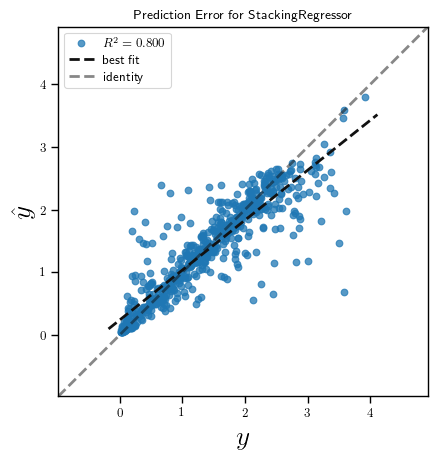

In [59]:
pyr.plot_model(tuned_z_reg, plot='error')

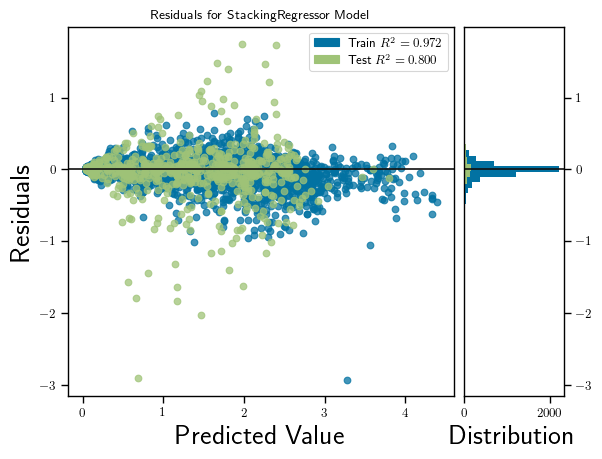

In [60]:
pyr.plot_model(tuned_z_reg, plot='residuals')

In [77]:
# pyr.plot_model(tuned_z_reg.final_estimator_, plot='feature_all')

In [61]:
pyr.plot_model(tuned_z_reg.final_estimator_, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mae
max_depth,8
max_features,0.33
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0001
min_impurity_split,None
min_samples_leaf,4


In [62]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mae
max_depth,8
max_features,0.33
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0001
min_impurity_split,None
min_samples_leaf,4


In [63]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [64]:
pyr.predict_model(tuned_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2231,0.1567,0.3958,0.8001,0.1609,0.2950,0.1576,0.0680,0.3958,0.1770,0.1724


,Z,Label
count,644.000000,644.000000
mean,1.355289,1.318657
std,0.885905,0.788589
min,0.015000,0.041790
25%,0.599250,0.619800
50%,1.317000,1.323950
75%,2.046000,1.985102
max,3.920000,3.803130


In [65]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2231,0.1567,0.3958,0.8001,0.1609,0.2950,0.1576,0.0680,0.3958,0.1770,0.1724


In [66]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [67]:
pyr.predict_model(final_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2231,0.1567,0.3958,0.8001,0.1609,0.2950,0.1576,0.0680,0.3958,0.1770,0.1724


,Z,Label
count,644.000000,644.000000
mean,1.355289,1.318657
std,0.885905,0.788589
min,0.015000,0.041790
25%,0.599250,0.619800
50%,1.317000,1.323950
75%,2.046000,1.985102
max,3.920000,3.803130


In [68]:
if save_model_flag:
    pyr.save_model(final_z_reg, gv.models_path + gv.full_z_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [50]:
if load_model_flag:
    final_z_reg = pyr.load_model(gv.models_path + gv.full_z_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [69]:
base_models_names = gf.get_base_estimators_names(final_z_reg)
base_models       = gf.get_base_estimators_models(final_z_reg)

In [70]:
print('Running data pre-processing:\n')
extended_data_z_df = gf.preprocess_data(final_z_reg, validation_df, base_models_names)

Running data pre-processing:



In [71]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_z_reg, extended_data_z_df)

In [72]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_z_df)

In [73]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [74]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for catboost...
Calculating for xgboost...
Calculating for gbr...


et             catboost              xgboost                  gbr  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W1_W3  22.594995      y_W1  19.108715       H_K  32.200336     W1_W3   
1       y_W1  12.529690     W1_W3  18.782846     W1_W3  28.423166      y_W1   
2   band_num  10.524117     W1_W2  11.821081      y_W1   7.857481       H_K   
3      W1_W2   8.987757       g_r   8.474224     W4mag   7.247443     W4mag   
4      W4mag   8.097756       r_z   5.265216     W1_W2   3.578701     W1_W2   
5       g_W1   7.640653       z_y   4.714382      K_W4   2.627099       g_r   
6        g_r   4.795515      g_W1   4.672835       y_J   2.379390      g_W1   
7        y_J   3.533170  band_num   4.470988       z_y   2.353687  band_num   
8        r_z   3.185421       H_K   3.631417       g_r   1.779828       y_J   
9        H_K   3.153512       r_i   3.362936       r_z   1.718831       z_y   
10       r_i   2.942136       i_z   3.329063  band_num   1.645085       r_z   
11       z_y   2.657873       y_J   2.732954       i_z   1.584915       i_y   
12       i_y   2.440545       i_y   2.663597      K_W3   1.565371       i_z   
13       g_J   2.228992     W4mag   2.473475       i_y   1.367495       r_i   
14       i_z   2.162111      K_W3   1.840710      g_W1   1.195891      K_W3   
15      K_W3   1.407691       g_J   1.470622       r_i   0.943455       g_J   
16       J_H   0.624967      K_W4   0.640572       J_H   0.792631      K_W4   
17      K_W4   0.493099       J_H   0.544367       g_J   0.739195       J_H   

               
   Importance  
0   49.634632  
1   15.222327  
2    6.737198  
3    5.270058  
4    5.262183  
5    4.223229  
6    3.196163  
7    2.590321  
8    2.313247  
9    1.561889  
10   1.027212  
11   0.734547  
12   0.671635  
13   0.595996  
14   0.446035  
15   0.312482  
16   0.110854  
17   0.089992

In [75]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,gbr,30.564235
1,xgboost,26.502673
2,catboost,14.697803
3,et,8.295003
4,W1_W3,3.362559
5,H_K,2.833335
6,band_num,2.386972
7,W1_W2,1.832373
8,r_i,1.598110
9,g_r,1.356465


In [76]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False).drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Importance
Feature,
W1_W3,30.7008
H_K,14.2218
y_W1,11.4769
W1_W2,6.8721
band_num,5.1448
g_r,4.7623
W4mag,4.6247
g_W1,3.6029
r_z,2.7907


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W1_W3	30.701
H_K	14.222
y_W1	11.477
W1_W2	6.872
band_num	5.145
g_r	4.762
W4mag	4.625
g_W1	3.603
r_z	2.791
r_i	2.769
z_y	2.690
i_z	2.645
y_J	2.420
i_y	1.681
K_W3	1.015
g_J	1.013
K_W4	1.013
J_H	0.557


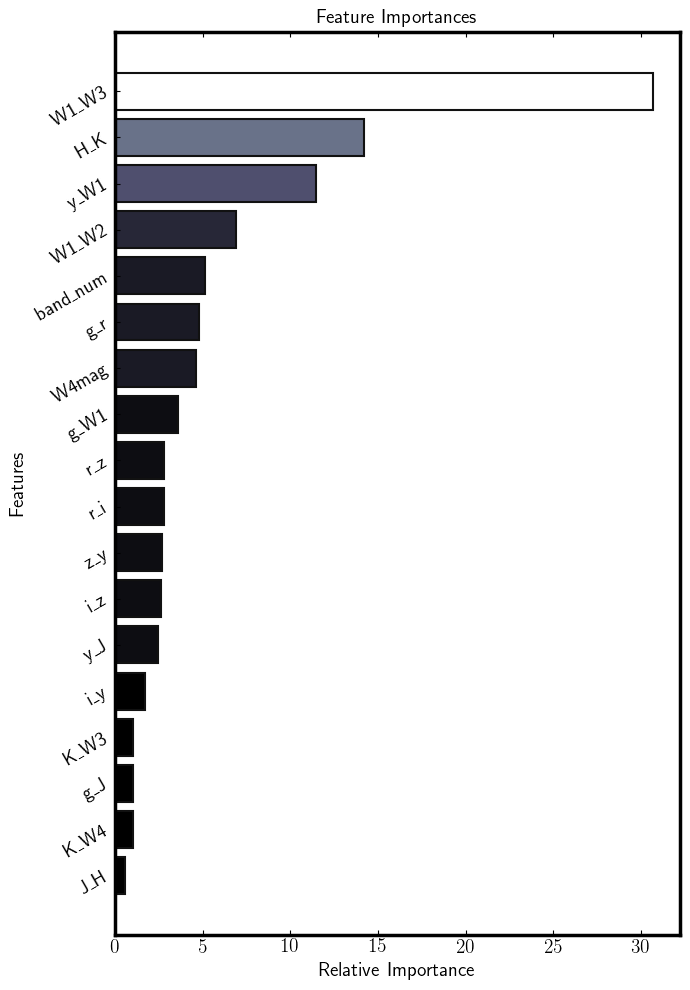

In [77]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_regression_z_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [78]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_z_reg, 'rf', 'regression')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,rf,et,catboost,xgboost,gbr
n_estimators,50,100.0000,NaN,100.0000,100.0000
max_depth,8,NaN,NaN,6.0000,3.0000
min_impurity_decrease,0.0001,0.0000,NaN,NaN,0.0000
max_features,0.3300,auto,NaN,NaN,None
bootstrap,True,False,NaN,NaN,NaN
criterion,mae,mse,NaN,NaN,NaN
min_samples_split,10,2.0000,NaN,NaN,2.0000
min_samples_leaf,4,1.0000,NaN,NaN,1.0000
learning_rate,NaN,NaN,0.0535,0.3000,0.1000
depth,NaN,NaN,6.0000,NaN,NaN


---

In [79]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 5,410
Size of test set is  644


In [80]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)
calib_prediction_reg      = pyr.predict_model(final_z_reg, data=calibration_df)
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0855,0.0213,0.1461,0.9720,0.0535,0.1172,0.0706,0.0331,0.1461,0.0538,0.0238


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2231,0.1567,0.3958,0.8001,0.1609,0.2950,0.1576,0.0680,0.3958,0.1770,0.1724


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1128,0.0495,0.2224,0.9357,0.0843,0.1485,0.0817,0.0379,0.2224,0.0882,0.0513


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2284,0.1741,0.4173,0.7829,0.1530,0.2611,0.1673,0.0760,0.4173,0.1570,0.1574


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2361,0.1664,0.4079,0.7831,0.1640,0.3241,0.1650,0.0762,0.4079,0.1968,0.1860


In [81]:
validation_prediction_reg.loc[:, [target_feat, 'Label']].describe()

,Z,Label
count,1618.000000,1618.000000
mean,1.334745,1.327917
std,0.876173,0.785579
min,0.003000,0.041160
25%,0.557000,0.688270
50%,1.280500,1.333535
75%,1.951750,1.956575
max,4.247000,3.919290


In [82]:
sigma_mad_train         = gf.sigma_mad(train_prediction_reg.loc[:, target_feat],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = gf.sigma_mad(test_prediction_reg.loc[:, target_feat],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = gf.sigma_mad(train_test_prediction_reg.loc[:, target_feat],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_calib         = gf.sigma_mad(calib_prediction_reg.loc[:, target_feat],         calib_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = gf.sigma_mad(validation_prediction_reg.loc[:, target_feat],    validation_prediction_reg.loc[:, 'Label'])

In [83]:
sigma_nmad_train        = gf.sigma_nmad(train_prediction_reg.loc[:, target_feat],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = gf.sigma_nmad(test_prediction_reg.loc[:, target_feat],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = gf.sigma_nmad(train_test_prediction_reg.loc[:, target_feat],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_calib        = gf.sigma_nmad(calib_prediction_reg.loc[:, target_feat],        calib_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = gf.sigma_nmad(validation_prediction_reg.loc[:, target_feat],   validation_prediction_reg.loc[:, 'Label'])

In [84]:
sigma_z_train           = gf.sigma_z(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = gf.sigma_z(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = gf.sigma_z(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_calib           = gf.sigma_z(calib_prediction_reg.loc[:, target_feat],           calib_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = gf.sigma_z(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

In [85]:
sigma_z_norm_train      = gf.sigma_z_norm(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = gf.sigma_z_norm(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = gf.sigma_z_norm(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_calib      = gf.sigma_z_norm(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = gf.sigma_z_norm(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

In [86]:
out_frac_train          = gf.outlier_frac(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
out_frac_test           = gf.outlier_frac(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
out_frac_train_test     = gf.outlier_frac(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
out_frac_calib          = gf.outlier_frac(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
out_frac_valid          = gf.outlier_frac(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

Display metrics as DataFrame

In [87]:
metrics_z = np.array([[len(train_prediction_reg),      sigma_mad_train,      sigma_nmad_train,\
                       sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [len(test_prediction_reg),       sigma_mad_test,       sigma_nmad_test,\
                       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [len(train_test_prediction_reg), sigma_mad_train_test, sigma_nmad_train_test,\
                       sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [len(calib_prediction_reg),      sigma_mad_calib,      sigma_nmad_calib,\
                       sigma_z_calib,      sigma_z_norm_calib,      out_frac_calib],\
                      [len(validation_prediction_reg), sigma_mad_valid,      sigma_nmad_valid,\
                       sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [88]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [89]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
    display(metrics_z_df)

,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Train,5410,0.0706,0.0331,0.1461,0.0538,0.0238
Test,644,0.1576,0.0680,0.3958,0.1770,0.1724
Train+Test,6721,0.0817,0.0379,0.2224,0.0882,0.0513
Calibration,667,0.1673,0.0760,0.4173,0.1570,0.1574
Validation,1618,0.1650,0.0762,0.4079,0.1968,0.1860


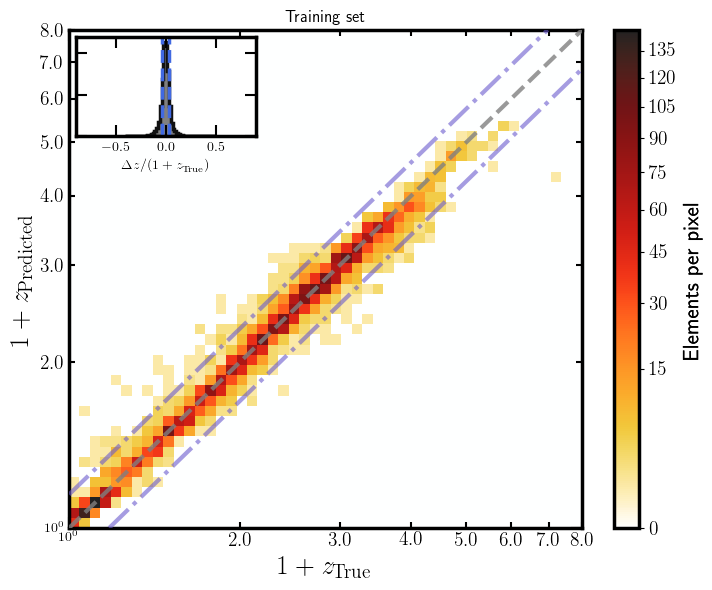

In [90]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(train_prediction_reg.loc[:, target_feat], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_redshift_04.pdf', bbox_inches='tight')
plt.show()

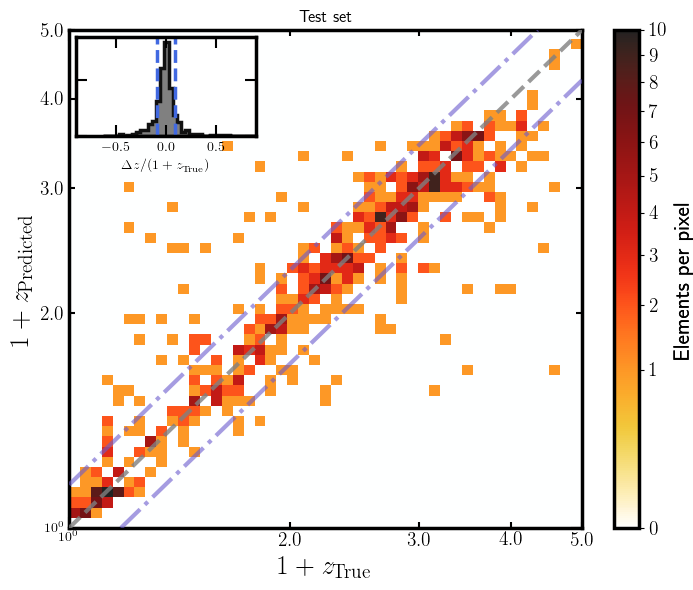

In [91]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(test_prediction_reg.loc[:, target_feat], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_test_redshift_04.pdf', bbox_inches='tight')
plt.show()

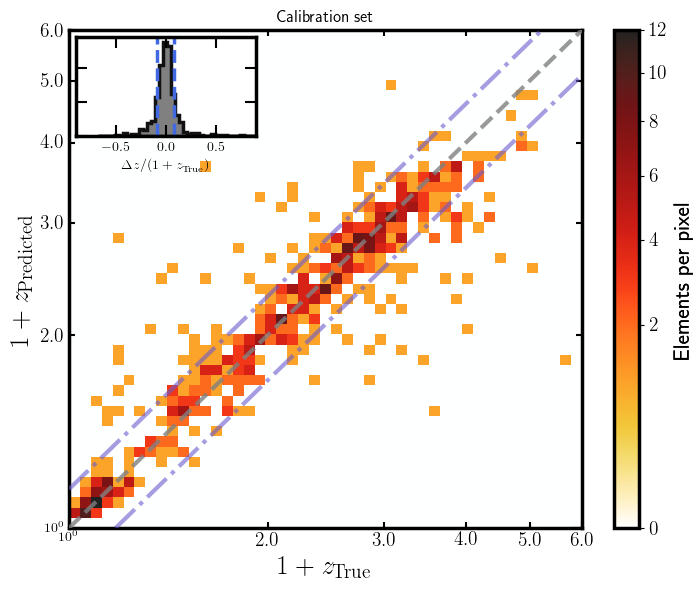

In [92]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(calib_prediction_reg.loc[:, target_feat], calib_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Calibration set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_calibration_redshift_04.pdf', bbox_inches='tight')
plt.show()

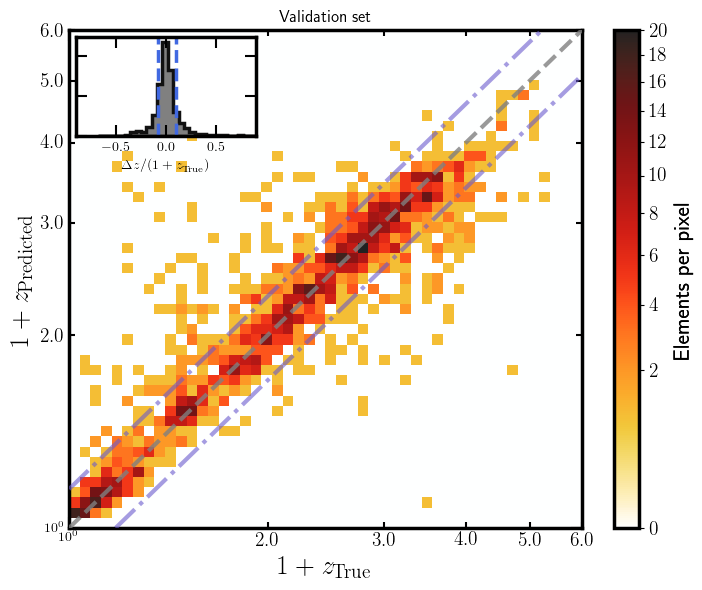

In [93]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_validation_redshift_04.pdf', bbox_inches='tight')
plt.show()

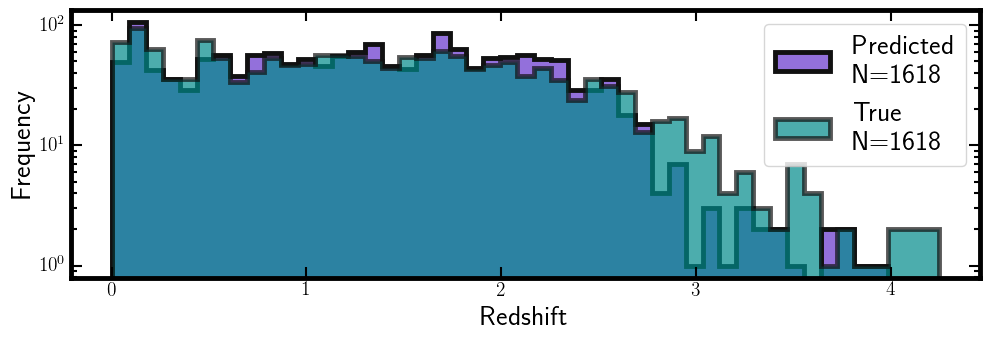

In [94]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, target_feat], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_true_predicted_z_04.pdf')
plt.show()

---

#### Redshift threshold

In order to understand where (in redshift) the predictions are far off from real values, we can use the evolution of the outlier fraction to obtain the point where that happens.

In [95]:
n_elems        = 50
z_range_lin    = np.linspace(0, np.nanmax(train_test_prediction_reg.loc[:, target_feat]), n_elems)
z_range_log    = np.logspace(np.log10(np.abs(np.nanmin(train_test_prediction_reg.loc[:, target_feat]))),\
                          np.log10(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))), n_elems)
z_range_lg_inv = np.abs(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))) - z_range_log

In [96]:
train_test_prediction_reg = train_test_prediction_reg.rename(columns={'Label': 'pred_Z'})

In [97]:
s_MAD_z_z_lin          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.outlier_frac,   target_feat,            'pred_Z')

In [98]:
s_MAD_z_z_log          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.outlier_frac,   target_feat,            'pred_Z')

In [99]:
s_MAD_z_z_log_inv      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log_inv    = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log_inv  = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.outlier_frac,   target_feat,            'pred_Z')

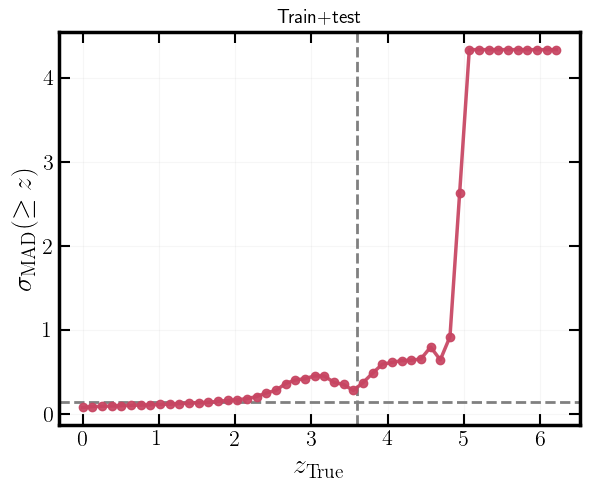

In [100]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_mad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

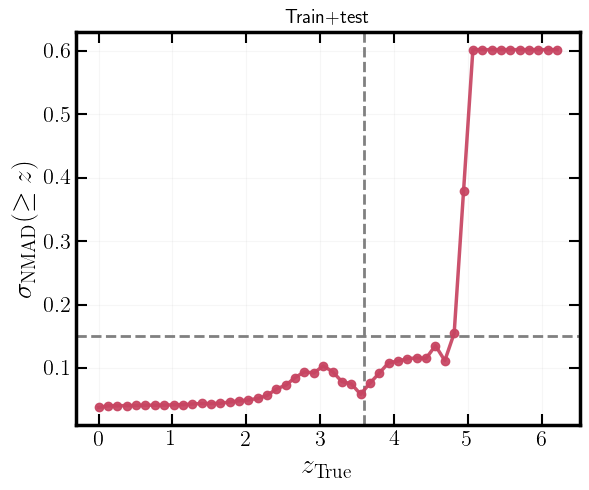

In [101]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_nmad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

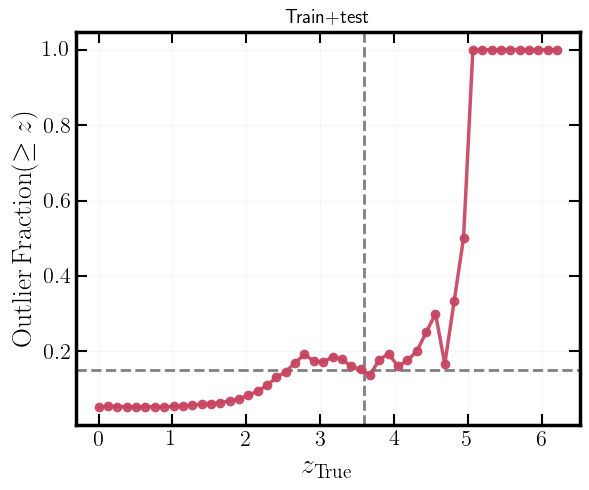

In [102]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

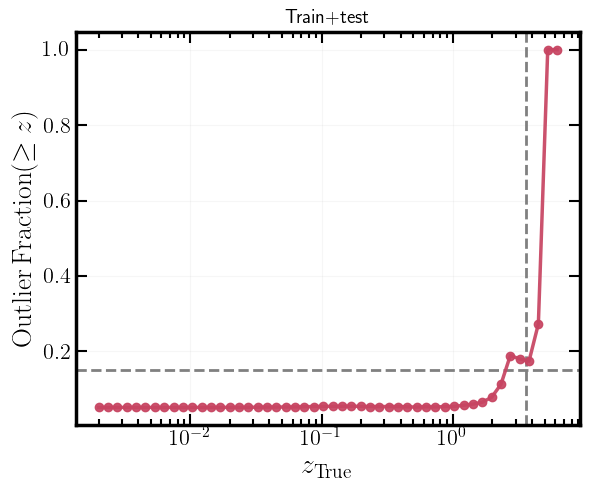

In [103]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='log', yscale='linear')
plot_metric_over_z(z_range_log, out_fr_z_z_log, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

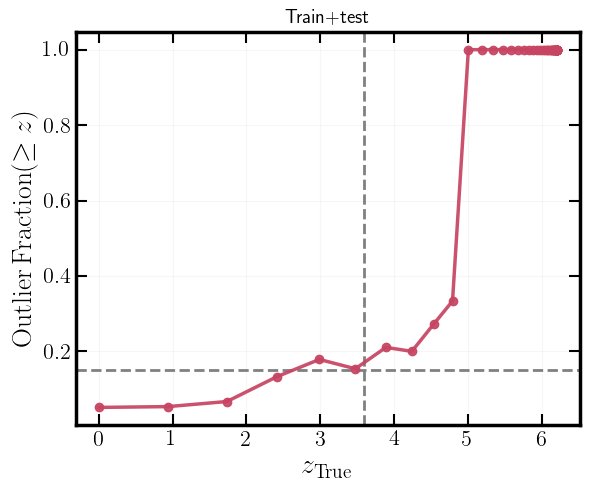

In [104]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lg_inv, out_fr_z_z_log_inv, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_inv_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()